# <center> Algorithmic Economics </center>
## <center> Assignment 5: Multi-Armed Bandits and Auctions </center>
### <center> Due date: April 29, 9:00am EDT, 2024 </center>
This assignment is designed for you to practice classical multi-armed bandit algorithms with simulated environments. You will be instructed step-by-step to implement the two most popularly referred bandit algorithms, explore-then- commit and UCB1, which we have carefully discussed in class.

## The environment setup: 
In a multi-armed bandit problem, the reward of different arms are assumed to be independent. In our simulated environment, the reward of each arm pull is sampled from a Gaussian distribution with unknown mean and known standard deviation, i.e., $r_{i,t} ∼ N(\mu_i,\sigma^2)$, where $i$ is arm index and $t$ is the timestamp. The agent can only observe the index of each arm and the sampled reward each time; and therefore, the learner should maintain sufficient statistics and construct reward estimator for each arm accordingly.

In [121]:
import numpy as np

# Define a class called MABEnvironment, which stands for "Multi-Armed Bandit Environment"

class MABEnvironment:
    def __init__(self, num_arms, noise_scale=0.3):
        self.n = num_arms
        self.arm_mean = np.zeros(self.n)
        self.noise_scale = noise_scale
        self.time = 0
    
    def gen_arms(self, range=(0, 1)):
        self.arm_mean = np.random.rand(self.n) * (range[1]-range[0]) + range[0]
    
    def get_arms(self):
        return self.arm_mean
    
    def get_optimal_arm(self):
        return np.argmax(self.arm_mean), np.max(self.arm_mean)
    
    def get_average_sub_optimality_gap(self): # Added for 1B
        optimal_arm, optimal_reward = self.get_optimal_arm() # Get the optimal arm and reward
        suboptimal_rewards = np.delete(self.arm_mean, optimal_arm) # Make a new array without the optimal arm
        sub_optimality_gaps = optimal_reward - suboptimal_rewards # Calculate sub-optimality gap
        average_sub_optimality_gap = np.mean(sub_optimality_gaps) # Calculate mean sub-optimality gap
        return average_sub_optimality_gap
    
    def run_algorithm(self, algorithm, num_iters=1000):
        regret_seq = []
        optimal_arm, optimal_reward = self.get_optimal_arm()

        for _ in range(num_iters):
            chosen_arm = algorithm.select_arm()
            reward = np.random.normal(self.arm_mean[chosen_arm], self.noise_scale)
            algorithm.update(chosen_arm, reward)
            regret_seq.append(optimal_reward - reward)
            self.time += 1

        return np.cumsum(regret_seq)

## Q1 Implement the explore-and-commit algorithm (30 pts): 
The detailed procedure of this algorithm can be found in our lecture slides for *“Lecture 8: Introduction to Online Learning”*. The only hyper-parameter we need to choose is the length of the exploration phase (denoted as m), whose theoretical value has also been discussed in the slides.
- Please implement this algorithm by completing the code snippets provided in this assignment **(15 pts)**.
- Please vary the total number of rounds T in the range of $[1000,5000]$ with step size 1000, vary the number of arms K in the range of $[10, 30]$ with step size 5, and repeat each experiment 5 times. Report your algorithm’s regret (mean and standard deviation) under the theoretical hyper-parameter setting of m **(8 pts)**.
- Can you find the best value of m when T = 5000 and K = 30? **(7 pts)**

### ETC algorithm implementation

In [129]:
class ETC:
    def __init__(self, num_arms, m=1):
        self.n = num_arms
        self.m = m
        self.arm_estimated_mean = np.zeros(self.n)
        self.arm_counts = np.zeros(self.n)
        self.t = 0
        self.exploration_phase = True # explicitly keep track of what phase we are in

    def select_arm(self):
        # INSERT CODE HERE
        # Exploreation phase
        if self.exploration_phase:
            for i in range(self.n): # loop through all the arms
                if self.arm_counts[i] < self.m: # if we haven't pulled an arm m times, pull it
                    return i 
            # This check updates the exploration_phase status based on all arms being pulled at least m times
            if all(count >= self.m for count in self.arm_counts):
                self.exploration_phase = False
        
        # Exploitation phase: Always select the best arm
        best_arm = np.argmax(self.arm_estimated_mean)
        return best_arm

        #pass

    def update(self, chosen_arm, reward):
        # INSERT CODE HERE
        # Only need to update counts and means for the exploration phase
        if self.exploration_phase:
            self.arm_counts[chosen_arm] += 1 # increase the arm pull count
            arm_count = self.arm_counts[chosen_arm] # get the arm_count for the pulled arm
            self.arm_estimated_mean[chosen_arm] = ( ((arm_count - 1) / arm_count) * self.arm_estimated_mean[chosen_arm] 
                                                + ((1 / arm_count) * reward ))
        self.t += 1
        #pass
    
    # Added for Q3 in the case where UCB goes first and picks the arm ETC would have picked
    def select_next_arm(self, initial_arm):
        # Exploration phase
        if self.exploration_phase:
            for i in range(self.n): # loop through all the arms
                if self.arm_counts[i] < self.m and i != initial_arm: # if we haven't pulled an arm m times, pull it
                    return i 
            # This check updates the exploration_phase status based on all arms being pulled at least m times
            if all(count >= self.m for count in self.arm_counts):
                self.exploration_phase = False
        
        # Exploitation phase: Always select the best arm
        best_arm = -1
        best_value = float('-inf')
        for i in range(self.n):
            if i != initial_arm and self.arm_estimated_mean[i] > best_value:
                best_arm = i
                best_value = self.arm_estimated_mean[i]
        return best_arm
    
    
    # Process for the ETC planner selecting an arm, assuming they know the means of all arms ---- NOT USED
    def planner_select_arm(self, arm_means, initial_arm):
        # Exploration phase
        for i in range(self.n): # loop through all the arms
            if self.arm_counts[i] < self.m and i != initial_arm: # if we haven't pulled an arm m times, pull it
                return i 
        
        # Exploitation phase
        best_arm = np.argmax(arm_means) # Pick the arm with the highest mean
        if best_arm == initial_arm: # Pick the arm with the second highest mean
            second_highest_mean = np.partition(arm_means, -2)[-2]
            # Now find the index of this value in the original array
            best_arm = np.where(arm_means == second_highest_mean)[0][0]
        return best_arm
        

        
        



### Performance of ETC under different $(K, T)$

Considering the convexity of the expression for the regrent bound, the average of the function is smaller than the function of the average, so we can define an average suboptimality gap and calculate the theoretical hyper-parameter setting of m given in lecture 8 by plugging in the average of suboptimality gaps.

In [130]:
import pandas as pd 
import math

num_arms = [10, 15, 20, 25, 30]
num_iters = [1000, 2000, 3000, 4000, 5000]
num_trials = 5

# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=num_arms, index=num_iters)

for k in num_arms:
    # setup environment
    env = MABEnvironment(num_arms=k)
    env.gen_arms(range=(1,2))
    arm_mean=env.get_arms()
    
    # Find out the value of Delta for different K
    # In lecture notes, Delta defined only when K=2 

    average_gap = env.get_average_sub_optimality_gap() # Calculate the average sub-optimality gap
    
    for t in num_iters:
        res = []

        theoretical_m = math.ceil( (4 / (average_gap**2)) * math.log( (t * (average_gap**2)) / 4) ) # Calculate m using average sub-optimality gap
        for trial in range(num_trials):
            algorithm = ETC(num_arms=k, m=theoretical_m) # ETC with theoretical m hyper-parameter
            accum_regret = env.run_algorithm(algorithm=algorithm, num_iters=t)
            res.append(accum_regret[-1])
        df.at[t, k] = str(round(np.mean(res), 0)) + ' +/- ' + str(round(np.std(res), 0))

print('The accumulated regret under different $(K, T)$ for ETC, format: mean +/- atd.')
df.head()

The accumulated regret under different $(K, T)$ for ETC, format: mean +/- atd.


,10,15,20,25,30
1000,303.0 +/- 6.0,413.0 +/- 5.0,432.0 +/- 7.0,510.0 +/- 7.0,561.0 +/- 13.0
2000,363.0 +/- 8.0,593.0 +/- 15.0,752.0 +/- 18.0,868.0 +/- 9.0,1033.0 +/- 8.0
3000,385.0 +/- 25.0,647.0 +/- 4.0,833.0 +/- 14.0,972.0 +/- 23.0,1180.0 +/- 12.0
4000,423.0 +/- 25.0,678.0 +/- 7.0,903.0 +/- 25.0,1007.0 +/- 16.0,1254.0 +/- 33.0
5000,413.0 +/- 20.0,708.0 +/- 23.0,931.0 +/- 39.0,1035.0 +/- 20.0,1316.0 +/- 30.0


### Find the best $m$ for ETC

100%|██████████| 100/100 [02:49<00:00,  1.69s/it]


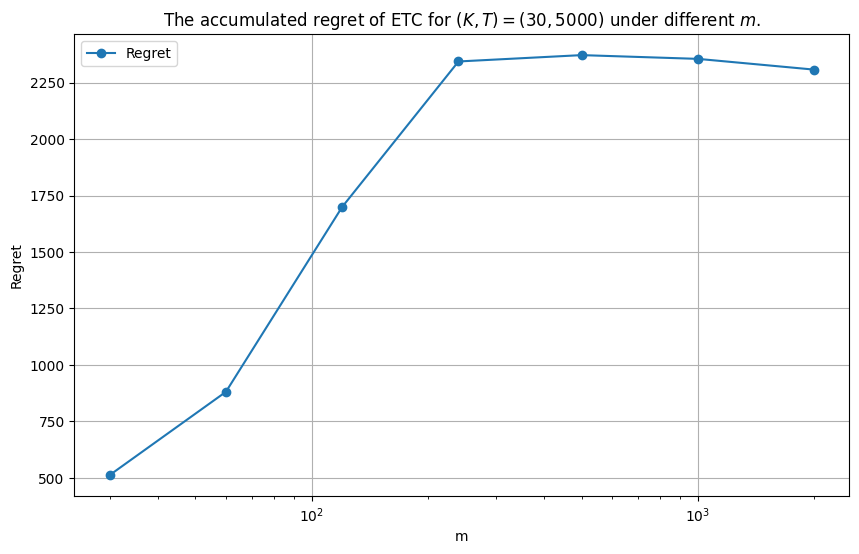

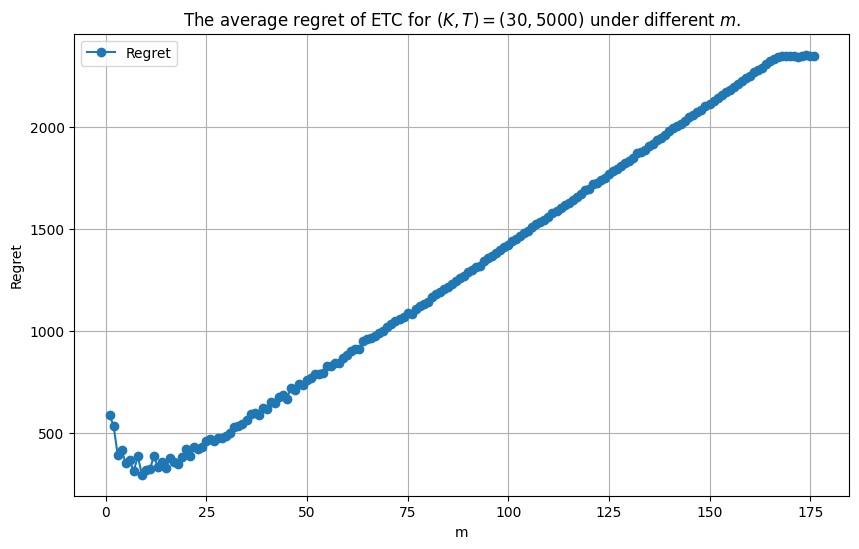

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

m_values = [30, 60, 120, 240, 500, 1000, 2000] # Can we use brute force to find the best m???
upper_bound = math.ceil(5000 / 30) # 167 m <= T/K
upper_bound = int(upper_bound)
num_trials = 100

regret = []
mrange_regret = []
for trial in tqdm(range(num_trials)):
    # setup environment
    env = MABEnvironment(num_arms=30)
    env.gen_arms(range=(1,2))

    res = []
    for m in m_values:
        algorithm = ETC(num_arms=30, m=m)
        accum_regret = env.run_algorithm(algorithm=algorithm, num_iters=5000)
        res.append(accum_regret[-1])
    regret.append(res)

    mrange_res = []
    for m in range(1, upper_bound + 10): # go a little past the upper bound of m, the regret should flatten
        algorithm = ETC(num_arms=30, m=m)
        accum_regret = env.run_algorithm(algorithm=algorithm, num_iters=5000)
        mrange_res.append(accum_regret[-1])
    mrange_regret.append(mrange_res)

avg_regret = np.mean(np.stack(regret), axis=0)  
mavg_regret = np.mean(np.stack(mrange_regret), axis=0)

plt.figure(figsize=(10, 6))
#plt.plot(m_values, res, label='Regret', marker='o')
plt.plot(m_values, avg_regret, label='Regret', marker='o')
plt.xscale('log')
plt.xlabel('m')
plt.ylabel('Regret')
plt.title('The accumulated regret of ETC for $(K, T)=(30, 5000)$ under different $m$.')
plt.legend()
plt.grid()
plt.show()

m_range = list(range(1, upper_bound + 10))
plt.figure(figsize=(10, 6))
#plt.plot(m_values, res, label='Regret', marker='o')
plt.plot(m_range, mavg_regret, label='Regret', marker='o')
#plt.xscale('log')
plt.xlabel('m')
plt.ylabel('Regret')
plt.title('The average regret of ETC for $(K, T)=(30, 5000)$ under different $m$.')
plt.legend()
plt.grid()
plt.show()

In [153]:
print(np.argmin(mavg_regret))
min(mavg_regret)


8


293.73060000850904

I programatically found the value of m that minimizes the average regret by running ETC with m values (1,2,3... T/K + 10). In theory, T/K should be the upper bound for m, but I decided to test the m values slightly greater than T/K for good measure, and to see if the average regret would flatten (which it did). The programatic minimization found 8 to be the value for m that yielded the lowest average regret. The second graph better illustrates the exploration/exploitation tradeoff. Looking at the plot, with m values near 0 we are not exploring enough, so our average regret is higher but decreasing as m approaches 8. As m increases from 8 to T/K + 10, we see average regret increase in what seems to be a seemingly linear fashion. This trend captures the issue of over-exploring when we should move on to the exploitation phase.

## Q2 Implement the UCB1 algorithm (30 pts): 
The detailed procedure of this algorithm can also be found in our lecture slides for “Lecture 8: Introduction to Online Learning”. 
- Please implement this algorithm by completing the code snippets provided in this assignment (15 pts).
- Now let’s compare UCB1 with explore-and-commit: please vary the total number of rounds T in the range of [1000,5000] with step size 1000, vary the number of arms K in the range of [10,30] with step size 5, and repeat each experiment 5 times. Report both algorithms’ regret (mean and standard deviation), using the theoretical hyper-parameter setting of $\alpha$ **(8 pts)**.
- In literature, we have a slightly different variant of UCB1, which chooses an arm by $a_t = argmax_{i} \hat{\mu}_{i, t-1}+ \alpha_t \sqrt{ \frac{2 log(t)}{T_{i,t-1}}}$. Can you finetune $\alpha_t$ to find the best performance of UCB1 when T = 5000 and K = 30? Is it better or worse than the corresponding best performance of
 explore-and-commit? (7 pts)


### UCB1 implementation

In [158]:
class UCB1:
    def __init__(self, num_arms, alpha=0.0):
        self.n = num_arms
        self.alpha = alpha
        self.arm_estimated_mean = np.zeros(self.n)
        self.arm_counts = np.zeros(self.n)
        self.t = 0

    def select_arm(self):
        # INSERT CODE HERE
        self.t += 1
        # pass
        # First Choose each action once
        for i in range(self.n):
            if self.arm_counts[i] < 1:
                return i
        
        # Then Choose the action maximizing 
        best_arm = -1 
        best_ucb = float('-inf')
        for i in range(self.n): # loop through all the arms
            if self.arm_counts[i] >= 1:
                ucb = self.arm_estimated_mean[i] + self.alpha * math.sqrt( (2 * math.log(self.t)) / (self.arm_counts[i]) )
                if ucb > best_ucb: # if we find a new largest UCB
                    best_arm = i # Pick that UCB
        return best_arm
        
    def update(self, chosen_arm, reward):
        # INSERT CODE HERE
        # pass
        self.arm_counts[chosen_arm] += 1 # increase the arm pull count
        arm_count = self.arm_counts[chosen_arm] # get the updated arm pull count

        self.arm_estimated_mean[chosen_arm] = ( ((arm_count - 1) / arm_count) * self.arm_estimated_mean[chosen_arm] 
                                               + ((1 / arm_count) * reward ))

        #self.t += 1 # update the rounds
    
    # For Question 3 in the case where ETC picks first and picks the arm UCB would choose
    def select_next_arm(self, initial_arm):
        for i in range(self.n):
            if i != initial_arm and self.arm_counts[i] < 1: # Just pass over the initial arm and pick the next one we haven't tried
                return i
        
        # Then Choose the second best action maximizing if need be
        best_arm = -1 
        best_ucb = float('-inf')
        for i in range(self.n): # loop through all the arms
            if self.arm_counts[i] >= 1:
                ucb = self.arm_estimated_mean[i] + self.alpha * math.sqrt( (2 * math.log(self.t)) / (self.arm_counts[i]) )
                if ucb > best_ucb and i != initial_arm: # if we find a new largest UCB that's not the arm we can not pick
                    best_arm = i # Pick that UCB
        return best_arm
        



### Performance of UCB1 under different $(K, T)$

In [151]:
import pandas as pd 

num_arms = [10, 15, 20, 25, 30]
num_iters = [1000, 2000, 3000, 4000, 5000]
num_trials = 5

# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=num_arms, index=num_iters) # ucb dataframe
etc_df = pd.DataFrame(columns=num_arms, index=num_iters) # etc dataframe

for k in num_arms:
    # setup environment
    env = MABEnvironment(num_arms=k)
    env.gen_arms(range=(1,2))

    average_gap = env.get_average_sub_optimality_gap() # Calculate the average sub-optimality gap

    for t in num_iters:
        res = [] # ucb results
        etc_res = [] # etc results

        theoretical_m = math.ceil( (4 / (average_gap**2)) * math.log( (t * (average_gap**2)) / 4) ) # Calculate m using average sub-optimality gap
        for trial in range(num_trials):
            algorithm = UCB1(num_arms=k, alpha=1.0)
            etc_algorithm = ETC(num_arms=k, m=theoretical_m)

            accum_regret = env.run_algorithm(algorithm=algorithm, num_iters=t)
            etc_accum_regret = env.run_algorithm(algorithm=etc_algorithm, num_iters=t)
            res.append(accum_regret[-1])
            etc_res.append(etc_accum_regret[-1])
        df.at[t, k] = str(round(np.mean(res), 0)) + ' +/- ' + str(round(np.std(res), 0))
        etc_df.at[t,k] = str(round(np.mean(etc_res), 0)) + ' +/- ' + str(round(np.std(etc_res), 0))

print('The accumulated regret under different $(K, T)$ for UCB1, format: mean +/- std.')
print(df.head())

print('The accumulated regret under different $(K, T)$ for ETC, format: mean +/- std.')
print(etc_df.head())

The accumulated regret under different $(K, T)$ for UCB1, format: mean +/- std.
                   10             15               20               25  \
1000    779.0 +/- 5.0    2.0 +/- 8.0    837.0 +/- 7.0    298.0 +/- 4.0   
2000   1556.0 +/- 8.0  -6.0 +/- 16.0  1673.0 +/- 16.0    598.0 +/- 9.0   
3000  2327.0 +/- 18.0   13.0 +/- 8.0   2526.0 +/- 9.0   906.0 +/- 12.0   
4000   3112.0 +/- 4.0   3.0 +/- 16.0   3359.0 +/- 8.0  1210.0 +/- 27.0   
5000  3904.0 +/- 12.0  12.0 +/- 10.0  4194.0 +/- 20.0  1510.0 +/- 26.0   

                   30  
1000    204.0 +/- 7.0  
2000   416.0 +/- 12.0  
3000    605.0 +/- 9.0  
4000    831.0 +/- 9.0  
5000  1031.0 +/- 25.0  
The accumulated regret under different $(K, T)$ for ETC, format: mean +/- std.
                  10              15              20               25  \
1000   289.0 +/- 9.0  455.0 +/- 11.0  400.0 +/- 11.0    524.0 +/- 9.0   
2000   347.0 +/- 9.0  526.0 +/- 17.0   769.0 +/- 8.0   898.0 +/- 22.0   
3000  375.0 +/- 11.0  591.0 +/- 2

### Find the best $\alpha$ for UCB1

100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


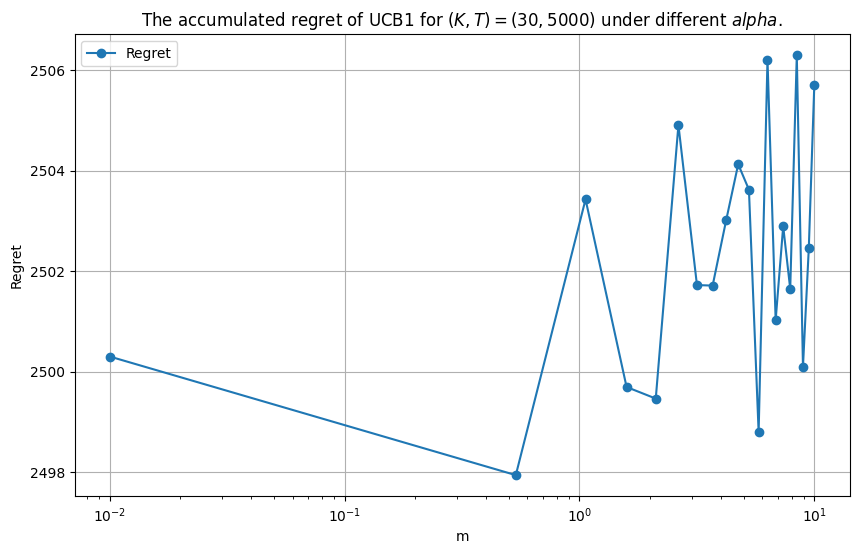

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

alpha_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 2.5, 3.0, 3.5, 4.0]
alpha_values = np.linspace(0.01, 10, 20)
num_trials = 100

regret = []
for trial in tqdm(range(num_trials)):
    # setup environment
    env = MABEnvironment(num_arms=30) #noise_scale=noise_scale)
    env.gen_arms(range=(1,2))
    res = []
    for alpha in alpha_values:
        algorithm = UCB1(num_arms=30, alpha=alpha)
        accum_regret = env.run_algorithm(algorithm=algorithm, num_iters=5000)
        res.append(accum_regret[-1])
    regret.append(res)

avg_regret = np.mean(np.stack(regret), axis=0)    

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, avg_regret, label='Regret', marker='o')
plt.xscale('log')
plt.xlabel('m')
plt.ylabel('Regret')
plt.title('The accumulated regret of UCB1 for $(K, T)=(30, 5000)$ under different $alpha$.')
plt.legend()
plt.grid()
plt.show()

In [149]:
print(np.argmin(avg_regret))
min(avg_regret)

1


2497.93540448095

Based on this graph it seems that the average regret does not fluctuate significantly for different values of alpha. I tested values for alpha using np.linspace(0.01, 10, 20), and I found that the best value for alpha was 1, yielding an average regret of 2497. The average regret for the different values of alpha tested ranged from approximately 2498 to 2506, suggesting that the alpha parameter does not have much impact on this implementation of UCB.

## Q3 Welfare analysis (40 pts): 
Define the welfare of the user of the algorithm in round t as the reward of the arm the algorithm pulls in that period. There are two users, one uses the explore-and-commit algorithm and one uses UCB1 algorithm to pull arms in each round t. They pull arms in random order such that if the first user gets to pull an arm first and pulls arm i then the second user can pull any other arm but arm i. Each of the two users pulls an arm first with probability exactly .5 in each round.

**(a)** Simulate sequences of arms pulled by each of 2 users over T = 100 rounds and repeat this process 1000 times. Using your simulation output, conclude which algorithm provides the highest average expected welfare (i.e., $\mathbb{E}[\frac{1}{T} \sum_{t=1}^{T} r_{i_t, t} ]$) where $i_t$ is the arm that a given user pulls in round t) to the user. **(20 pts)**

**(b)** Compare the average expected welfare provided by the two algorithms which you evaluated in question (a) with the expected welfare that would be provided by a central planner who knows the realizations of rewards of arms before assigning them. **(20 pts)**

For (b), I implemented the planners under the assumption that they knew the true mean reward for each arm.

### Setup

In [171]:
num_arms=10
m=13
alpha=1
# You can change the values set above

def run_experiment(num_rounds=100, num_repeats=1000):
    
    # Initialize variables to store cumulative (from repeats) rewards for each player
    etc_rewards = np.zeros(num_repeats)
    ucb_rewards = np.zeros(num_repeats)
    # INSERT INITIALIZATION HERE
    etc_planner_rewards = np.zeros(num_repeats)
    ucb_planner_rewards = np.zeros(num_repeats)

    # Repeat the experiment for num_repeats times
    
    for repeat in range(num_repeats):
        # Initialize the multi-armed bandit environment
        env = MABEnvironment(num_arms,noise_scale=0.3)
        env.gen_arms(range=(1, 2))

        optimal_arm, optimal_reward = env.get_optimal_arm()

        # Initialize the ETC and UCB1 players
        etc_player = ETC(num_arms, m)
        ucb_player = UCB1(num_arms, alpha)

        # Play the game for num_rounds rounds
        for i in range(num_rounds):
            # Realize the rewards of each arm
            rewards = np.zeros(num_arms)
            for i in range(num_arms):
                rewards[i] = np.random.normal(env.arm_mean[i], env.noise_scale)

            # ETC player goes first if random value less than 0.5
            if np.random.rand() < 0.5: 
                # ETC player makes a move
                etc_arm = etc_player.select_arm()
                etc_reward = np.random.normal(env.arm_mean[etc_arm], env.noise_scale)
                etc_player.update(etc_arm, etc_reward)

                # ETC planner picks best arm?
                etc_planner_arm = np.argmax(rewards)
                etc_planner_reward =  max(rewards)

                # UCB player makes a move
                ucb_arm = ucb_player.select_arm()
                if ucb_arm == etc_arm: #if the UCB player picks the same arm as the UTC player
                    ucb_arm = ucb_player.select_next_arm(etc_arm)
                ucb_reward = np.random.normal(env.arm_mean[ucb_arm], env.noise_scale)
                ucb_player.update(ucb_arm, ucb_reward)

                # UCB planner picks second best reward
                ucb_planner_reward = np.partition(rewards, -2)[-2]
                # Now find the index of this value in the original array
                ucb_planner_arm = np.where(rewards == ucb_planner_reward)[0][0]
                #ucb_planner_reward = np.random.normal(env.arm_mean[ucb_planner_arm], env.noise_scale)
            else:
                # UCB player goes first
                ucb_arm = ucb_player.select_arm()
                ucb_reward = np.random.normal(env.arm_mean[ucb_arm], env.noise_scale)
                ucb_player.update(ucb_arm, ucb_reward)

                # UCB planner picks best arm?
                ucb_planner_arm = np.argmax(rewards)
                ucb_planner_reward = max(rewards)

                # ETC player goes second
                etc_arm = etc_player.select_arm()
                if etc_arm == ucb_arm:
                    etc_arm = etc_player.select_next_arm(ucb_arm)
                etc_reward = np.random.normal(env.arm_mean[etc_arm], env.noise_scale)
                etc_player.update(etc_arm, etc_reward)

                # ETC planner picks second best true mean
                etc_planner_reward = np.partition(rewards, -2)[-2]
                # Now find the index of this value in the original array
                etc_planner_arm = np.where(rewards == etc_planner_reward)[0][0]
                #etc_planner_reward = np.random.normal(env.arm_mean[etc_planner_arm], env.noise_scale)


        
            # Update cumulative rewards
            etc_rewards[repeat] += etc_reward
            ucb_rewards[repeat] += ucb_reward
            
            # Update planner's rewards
            etc_planner_rewards[repeat] += etc_planner_reward
            ucb_planner_rewards[repeat] += ucb_planner_reward
        
        # Average welfare per 100 rounds
        etc_rewards[repeat] /= 100
        ucb_rewards[repeat] /= 100
        etc_planner_rewards[repeat] /= 100
        ucb_planner_rewards[repeat] /= 100

    # Compute expected rewards per round
    etc_avg_rewards = np.mean(etc_rewards)
    ucb_avg_rewards = np.mean(ucb_rewards)
    etc_avg_rewards_planner = np.mean(etc_planner_rewards)
    ucb_avg_rewards_planner = np.mean(ucb_planner_rewards)

        #INSERT CODE HERE

    return etc_avg_rewards, ucb_avg_rewards, etc_avg_rewards_planner, ucb_avg_rewards_planner

### Result Comparison

In [172]:
etc_avg_rewards, ucb_avg_rewards, etc_avg_rewards_planner, ucb_avg_rewards_planner = run_experiment(100,1000)
print("Part a:")
print("Average welfare for ETC user is", np.round(etc_avg_rewards,3))
print("Average welfare for UCB1 user is", np.round(ucb_avg_rewards,3))
print("Part b:")
print("Average welfare for ETC user is", np.round(etc_avg_rewards_planner,3))
print("Average welfare for UCB1 user is", np.round(ucb_avg_rewards_planner,3))

Part a:
Average welfare for ETC user is 1.502
Average welfare for UCB1 user is 1.493
Part b:
Average welfare for ETC user is 2.03
Average welfare for UCB1 user is 2.03


Based on the results, it seems that the average expected welfare for a regular ETC player and a regular UCB player are nearly identical at approximately 1.5. The average expected welfare for a planner who knows the realized reward of each arm pull is approximately 2.03, which is greater than the average expected welfare for the UCB player and the ETC player.